In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import numpy as np
import torch.optim as optim
import Model

In [2]:
import Utils
npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[1, 0].npy"
loaded_data = Utils.read_npz_file(npz_file_path)

device = 'cuda'
data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)


prediction_horizion = 50
prediction_input_size = 200
epochs = 2
_divition_factr = 7
inception = Model.Encoder_Decoder(prediction_input_size).to(device)
criterion = torch.nn.MSELoss()


In [3]:
optimizer = optim.SGD(inception.parameters(),
                      lr=5e-2,
                      momentum=0.9,
                      weight_decay=1e-4)

loss_t = []

ll = (data_tensor.shape[-1]//prediction_input_size)-1
for epoch in tqdm.tqdm(range(1,epochs)):
    loop_train = tqdm.tqdm(range(ll),total=ll,desc="train",position=0,leave=True)
    
    loss_train_list = []
    
    for Batch in loop_train:
        optimizer.zero_grad()
        
        x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]+(torch.rand(size=[prediction_input_size],device=device)/_divition_factr)
        _x = x
        y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+prediction_horizion]

        prediction_list = torch.zeros(size=[prediction_horizion]).to(device)

        decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
        for i in range(prediction_horizion):
            # prediction = inception.forward(x)
            prediction,(decoder_hidden, decoder_cell) = inception.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)#
            x =  torch.cat([x[1:],prediction],dim=0)
            prediction_list[i] = prediction


        loss_train = criterion(prediction_list, y)
        # Back propagation
        loss_train.backward()
        # Update model parameters
        optimizer.step()
        loss_train_list.append(loss_train)
        
        if Batch%10 == 0:
            loop_train.set_description(f"Train {epoch}- iteration : {Batch}")
            loop_train.set_postfix(
                loss_batch="{:.7f}".format(torch.tensor(loss_train_list).mean()),refresh=True,)
            
    loss_t.append(torch.tensor(loss_train_list).mean())

  0%|          | 0/1 [00:54<?, ?it/s]


KeyboardInterrupt: 

# ChangeLog

1.  waiting to solution settle
2.  using only th acceleration data instead of the v and x
3.  

# Note
1.  try to remove the drop out in LSTM

2.  BE SURE data for chaotic case in Clean. (Training)
3.  Be sure for integration data is noise free.(Integrating)

In [4]:
prediction_list, y

(tensor([ 0.1107,  0.0925,  0.1005,  0.1300,  0.1707,  0.2311,  0.3066,  0.3801,
          0.4415,  0.4787,  0.5025,  0.5122,  0.5084,  0.4943,  0.4665,  0.4206,
          0.3548,  0.2782,  0.1937,  0.1261,  0.0690,  0.0116, -0.0422, -0.0912,
         -0.1405, -0.1862, -0.2240, -0.2518, -0.2666, -0.2684, -0.2590, -0.2374,
         -0.2049, -0.1629, -0.1125, -0.0546,  0.0096,  0.0791,  0.1493,  0.2159,
          0.2833,  0.3545,  0.4100,  0.4415,  0.4529,  0.4501,  0.4294,  0.3911,
          0.3448,  0.2901], device='cuda:0', grad_fn=<CopySlices>),
 tensor([ 0.0877,  0.1184,  0.1541,  0.1941,  0.2375,  0.2828,  0.3284,  0.3720,
          0.4113,  0.4437,  0.4669,  0.4788,  0.4780,  0.4636,  0.4356,  0.3950,
          0.3434,  0.2830,  0.2164,  0.1466,  0.0761,  0.0077, -0.0563, -0.1141,
         -0.1640, -0.2049, -0.2360, -0.2565, -0.2662, -0.2649, -0.2526, -0.2296,
         -0.1962, -0.1531, -0.1015, -0.0426,  0.0218,  0.0895,  0.1581,  0.2248,
          0.2867,  0.3411,  0.3854,  0.41

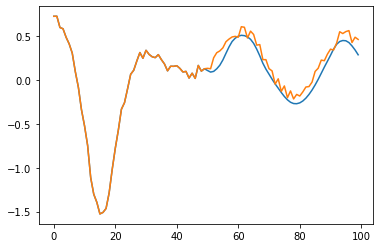

In [5]:
plt.plot( torch.concat([_x[-50:],prediction_list[:]]                                                           ).detach().cpu().numpy() , label="Displacement")
plt.plot( torch.concat([_x[-50:],y[:]+torch.rand(size=[prediction_horizion],device=device)/_divition_factr]  ).detach().cpu().numpy() , label="Displacement")
# plt.savefig(("gamma=0.37.jpg"), bbox_inches='tight')

In [9]:
with torch.inference_mode():
    Batch = 2
    pred_hor = 6000
    x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]+(torch.rand(size=[prediction_input_size],device=device)/_divition_factr)
    y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+pred_hor]

    prediction_list = torch.zeros(size=[pred_hor]).to(device)

    decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
    for i in range(pred_hor):
        # prediction = inception.forward(x)
        prediction,(decoder_hidden, decoder_cell) = inception.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)#
        x =  torch.cat([x[1:],prediction],dim=0)
        prediction_list[i] = prediction



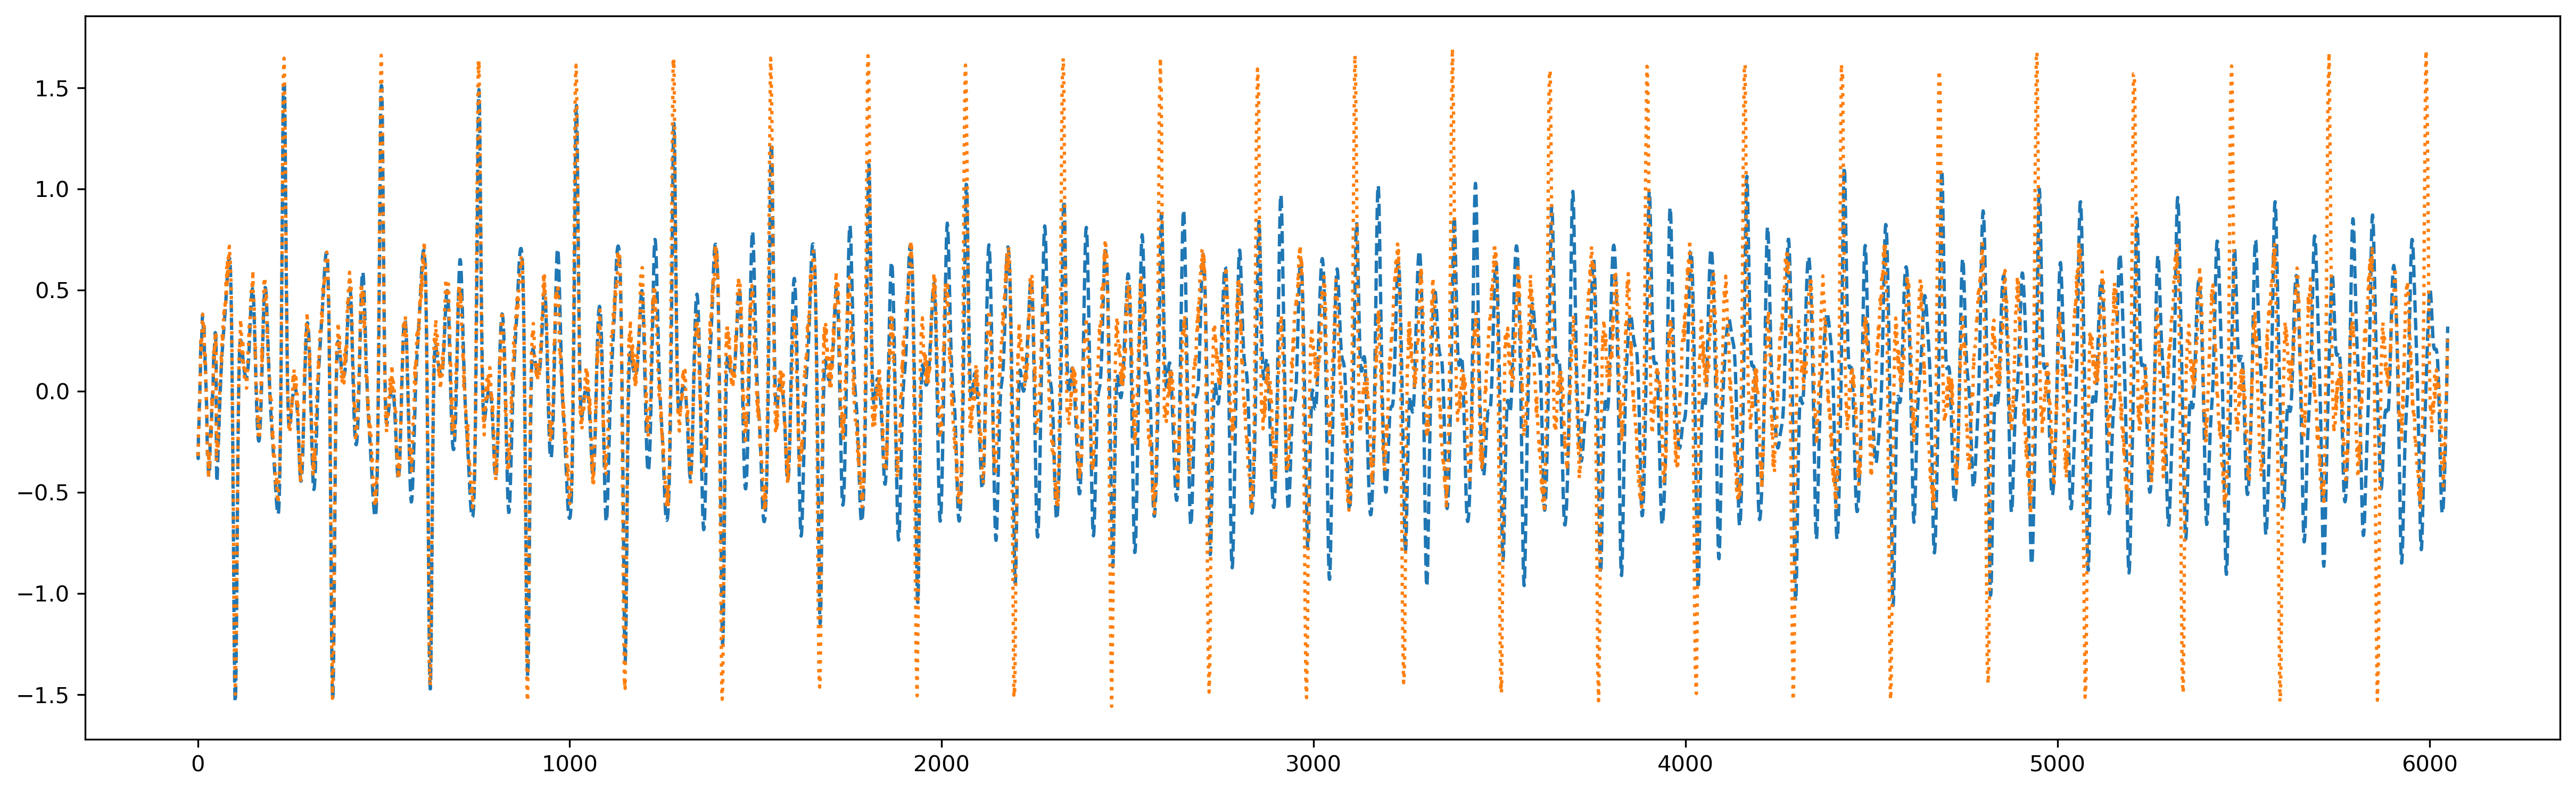

In [10]:
plt.figure(figsize=(20, 6),dpi=300)
plt.plot( torch.concat([_x[-50:],prediction_list[:]]                                              ).detach().cpu().numpy() ,linestyle='dashed', label="Displacement")
plt.plot( torch.concat([_x[-50:],y[:]+torch.rand(size=[pred_hor],device=device)/_divition_factr]  ).detach().cpu().numpy() ,linestyle='dotted', label="Displacement")

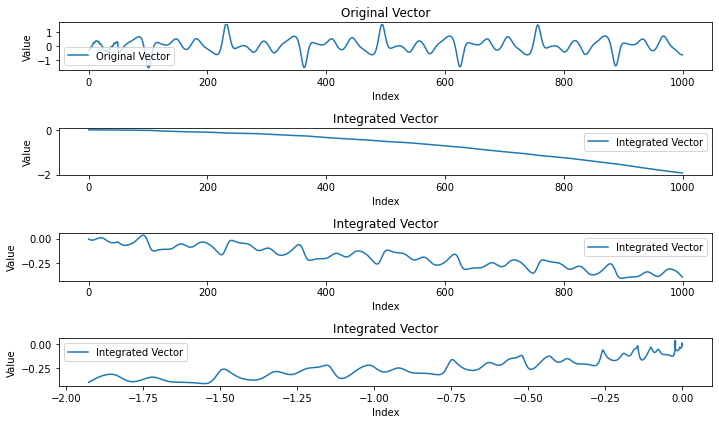

In [17]:
def integrate_and_plot(vector, dt=0.01):
    V = np.cumsum(vector-0.5/_divition_factr) * dt
    X = np.cumsum(V) * dt

    plt.figure(figsize=(10, 6))
    plt.subplot(4, 1, 1)
    plt.plot(vector, label='Original Vector')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Original Vector')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(X, label='Integrated Vector')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Integrated Vector')
    plt.legend()


    plt.subplot(4, 1, 3)
    plt.plot(V, label='Integrated Vector')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Integrated Vector')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(X,V, label='Integrated Vector')
    # plt.xlim(-0.25, 0.25)
    # plt.ylim(-0.25, 0.25)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Integrated Vector')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage

vector = torch.concat([_x[-50:],prediction_list[:]])[:1000].detach().cpu().numpy()
integrate_and_plot(vector)
